# Scoring Each Events for the Features


We aim to calculate a score for each event based on its $\texttt{AvgTone}$ value and its distance from a defined baseline route. The score will then be aggregated for events occurring on the same day. The process is as follows:

### Definitions
$$
\begin{align*}
&\text{Let } (\mathbf{X}_0, \mathbf{Y}_0) \text{ represent the coordinates of the home.} \\
&\text{Let } (\mathbf{X}_1, \mathbf{Y}_1) \text{ represent the coordinates of the work location.} \\
&\text{Let } (\mathbf{x}_i, \mathbf{y}_i) \text{ be the coordinates of event } i \in E \text{ (the set of all events).} \\
&\text{The line connecting home and work (baseline route) is parameterized as:} \\
&\mathbf{r}(t) = (1 - t)(\mathbf{X}_0, \mathbf{Y}_0) + t(\mathbf{X}_1, \mathbf{Y}_1), \quad t \in [0,1].
\end{align*}
$$

---

Lets pull in the data and set the values.

---

In [105]:
import pandas as pd

target_data = pd.read_csv('csv/target_data.csv')
target_data.head()


,Date,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,2024-08-23,145,"Union Park, Illinois, United States",41.8839,-87.6648,-3.046968
1,2024-08-22,145,"Union Park, Illinois, United States",41.8839,-87.6648,0.000000
2,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654
3,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654
4,2024-06-27,145,"Buckingham Fountain, Illinois, United States",41.8756,-87.6189,-7.052186


In [106]:
target_location = pd.read_csv('csv/target_location.csv')
target_location.head()

,lat,lon,event
0,41.911188,-87.675144,home
1,41.873000,-87.627650,school
2,41.865756,-87.684843,expanded_start
3,41.918433,-87.617952,expanded_end


In [107]:
X_0 = target_location.loc[target_location['event'] == 'home', 'lat'].values[0]
Y_0 = target_location.loc[target_location['event'] == 'home', 'lon'].values[0]
X_1 = target_location.loc[target_location['event'] == 'school', 'lat'].values[0]
Y_1 = target_location.loc[target_location['event'] == 'school', 'lon'].values[0]
X_0, Y_0, X_1, Y_1

(41.91118832433419, -87.67514378155508, 41.87300017458362, -87.62765043486581)

In [108]:
import folium
import numpy as np

import matplotlib.pyplot as plt

# Create a map centered around the midpoint of the baseline route
mid_lat = (X_0 + X_1) / 2
mid_lon = (Y_0 + Y_1) / 2
m = folium.Map(location=[mid_lat, mid_lon], zoom_start=13)

# Add markers for the start and end points
folium.Marker([X_0, Y_0], popup='Home', icon=folium.Icon(color='green')).add_to(m)
folium.Marker([X_1, Y_1], popup='Work', icon=folium.Icon(color='red')).add_to(m)

# Add a line for the baseline route
folium.PolyLine(locations=[[X_0, Y_0], [X_1, Y_1]], color='blue').add_to(m)

# Display the map
m

### Distance Calculation
The perpendicular distance $d_i$ from event $i$ to the baseline route is computed as:
$$
\begin{align*}
d_i = \frac{|(\mathbf{X}_1 - \mathbf{X}_0)(\mathbf{Y}_0 - \mathbf{y}_i) - (\mathbf{Y}_1 - \mathbf{Y}_0)(\mathbf{X}_0 - \mathbf{x}_i)|}{\sqrt{(\mathbf{X}_1 - \mathbf{X}_0)^2 + (\mathbf{Y}_1 - \mathbf{Y}_0)^2}}.
\end{align*}
$$


In [109]:
# Calculate the perpendicular distance d_i for each event
target_data['d_i'] = target_data.apply(
    lambda row: abs((X_1 - X_0) * (Y_0 - row['ActionGeo_Long']) - (Y_1 - Y_0) * (X_0 - row['ActionGeo_Lat'])) / np.sqrt((X_1 - X_0)**2 + (Y_1 - Y_0)**2),
    axis=1
)

target_data.head()


,Date,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone,d_i
0,2024-08-23,145,"Union Park, Illinois, United States",41.8839,-87.6648,-3.046968,0.014785
1,2024-08-22,145,"Union Park, Illinois, United States",41.8839,-87.6648,0.000000,0.014785
2,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654,0.014785
3,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654,0.014785
4,2024-06-27,145,"Buckingham Fountain, Illinois, United States",41.8756,-87.6189,-7.052186,0.007509


### Event Scoring

Each event $i$ is assigned a score based on its \texttt{AvgTone} value and its distance $d_i$:
$$
\begin{align*}
\text{Score}_i = \frac{\text{AvgTone}_i}{d_i}.
\end{align*}
$$

In [110]:
target_data['Score'] = target_data['AvgTone'] / target_data['d_i']
target_data.head()

,Date,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone,d_i,Score
0,2024-08-23,145,"Union Park, Illinois, United States",41.8839,-87.6648,-3.046968,0.014785,-206.091176
1,2024-08-22,145,"Union Park, Illinois, United States",41.8839,-87.6648,0.000000,0.014785,0.000000
2,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654,0.014785,-292.173275
3,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654,0.014785,-292.173275
4,2024-06-27,145,"Buckingham Fountain, Illinois, United States",41.8756,-87.6189,-7.052186,0.007509,-939.118761


### Daily Aggregated Score
For all events $j$ occurring on the same day as event $i$, the daily aggregated score is computed as:
$$
\begin{align*}
\text{Daily Score}_{\text{day}} = \sum_{j \in \text{same day}} \frac{\text{AvgTone}_j}{d_j}.
\end{align*}
$$

In [111]:
# Convert Date to datetime
target_data['Date'] = pd.to_datetime(target_data['Date'], format='%Y-%m-%d')

# Aggregate target_data by date and calculate the total score for each day
aggregated = target_data.groupby('Date').agg({'Score': 'sum'}).reset_index()
aggregated.columns = ['Date', 'Total Score']

# Create a date range and reindex the dataframe
all_dates = pd.date_range(start=aggregated['Date'].min(), end=pd.Timestamp.today())
scored_events = aggregated.set_index('Date').reindex(all_dates, fill_value=0).reset_index()

# Rename columns
scored_events.columns = ['Date', 'Total Score']

# Display the resulting DataFrame
scored_events


,Date,Total Score
0,2015-12-25,-589.428382
1,2015-12-26,0.000000
2,2015-12-27,0.000000
3,2015-12-28,0.000000
4,2015-12-29,0.000000
...,...,...
3286,2024-12-23,0.000000
3287,2024-12-24,0.000000
3288,2024-12-25,0.000000
3289,2024-12-26,0.000000


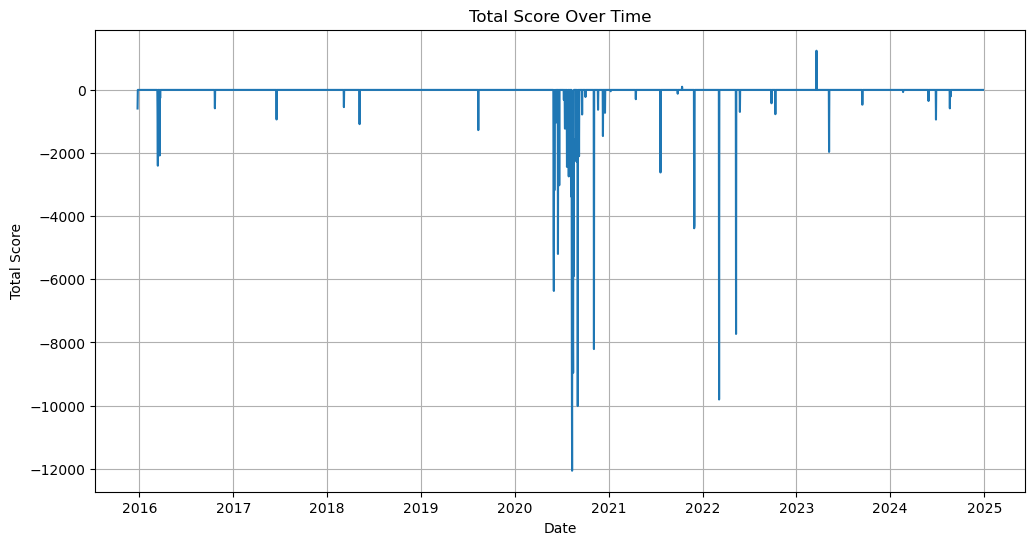

In [112]:
import matplotlib.pyplot as plt

# Plot the Total Score over time
plt.figure(figsize=(12, 6))
plt.plot(scored_events['Date'], scored_events['Total Score'], linestyle='-')
plt.title('Total Score Over Time')
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.grid(True)
plt.show()

---

Still don't really understand the positive scores here...

---

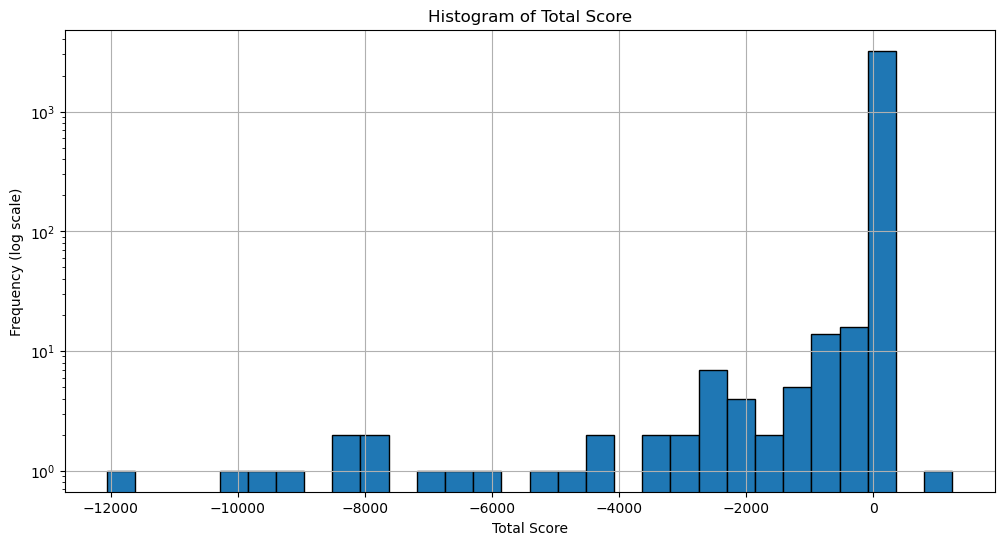

In [113]:
plt.figure(figsize=(12, 6))
plt.hist(scored_events['Total Score'], bins=30, edgecolor='black', log=True)
plt.title('Histogram of Total Score')
plt.xlabel('Total Score')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()

---

Log y for visibility.

---

---

Save labels.

---

In [114]:
scored_events.to_csv('model_csv/scored_events.csv', index=False)